# Identify malaria cells using cnn

## What is CNN?
Convolutional neural network - I will create one cnn using keras with tensorflow backend. We will use it to make identify malaria cells. Dataset is from https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria. Due to its size I'm going to put it in git ignore file.

In [1]:
import numpy as np
np.random.seed(1000)
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

In [2]:
import keras
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from keras.models import Sequential

Using TensorFlow backend.


### Preparing image dataset
Here I am resizing images to 64x64. Parasitized images will have label 0 and uninfected 1

In [3]:
import os
import cv2
from PIL import Image

In [4]:
data_dir = 'cell_images/'
SIZE = 64 
dataset =[]
labels = []

In [5]:
parasitized_images = os.listdir(data_dir + 'Parasitized/')
for i, image_name in enumerate(parasitized_images):
    try:
        if (image_name.split('.')[1] == 'png'):
            image = cv2.imread(data_dir + 'Parasitized/' + image_name)
            image = Image.fromarray(image, 'RGB')
            image = image.resize((SIZE, SIZE))
            dataset.append(np.array(image))
            labels.append(0)
    except Exception:
        print("Could not read image {} with name {}".format(i, image_name))

In [6]:
uninfected_images = os.listdir(data_dir + 'Uninfected/')
for i, image_name in enumerate(uninfected_images):
    try:
        if (image_name.split('.')[1] == 'png'):
            image = cv2.imread(data_dir + 'Uninfected/' + image_name)
            image = Image.fromarray(image, 'RGB')
            image = image.resize((SIZE, SIZE))
            dataset.append(np.array(image))
            labels.append(1)
    except Exception:
        print("Could not read image {} with name {}".format(i, image_name))

### Displaying images
Let's check 5 random images from each type

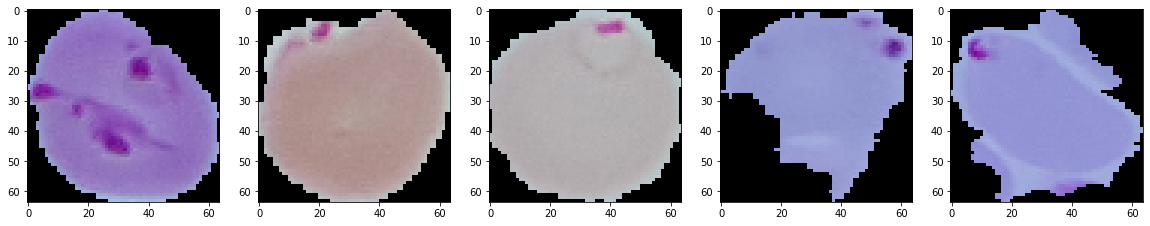

In [7]:
plt.figure(figsize = (20, 12))
for index, image_index in enumerate(np.random.randint(len(parasitized_images), size = 5)):
    plt.subplot(1, 5, index+1)
    plt.imshow(dataset[image_index])

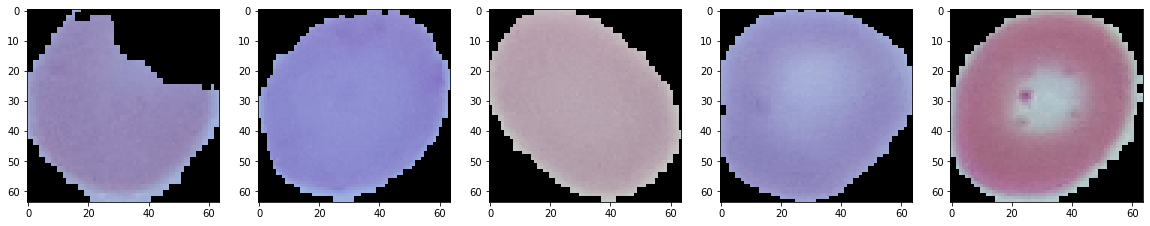

In [8]:
plt.figure(figsize = (20, 12))
for index, image_index in enumerate(np.random.randint(len(uninfected_images), size = 5)):
    plt.subplot(1, 5, index+1)
    plt.imshow(dataset[len(parasitized_images) + image_index])

It looks like everything loaded correctly so we can start with building our cnn

### Creating cnn

In [9]:
my_cnn = Sequential()
my_cnn.add(Convolution2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))
my_cnn.add(MaxPooling2D(pool_size = (2, 2), data_format="channels_last"))
my_cnn.add(BatchNormalization(axis = -1))
my_cnn.add(Dropout(0.2))
my_cnn.add(Convolution2D(32, (3, 3), activation = 'relu'))
my_cnn.add(MaxPooling2D(pool_size = (2, 2), data_format="channels_last"))
my_cnn.add(BatchNormalization(axis = -1))
my_cnn.add(Dropout(0.2))
my_cnn.add(Flatten())
my_cnn.add(Dense(activation = 'relu', units=512))
my_cnn.add(BatchNormalization(axis = -1))
my_cnn.add(Dropout(0.2))
my_cnn.add(Dense(activation = 'relu', units=256))
my_cnn.add(BatchNormalization(axis = -1))
my_cnn.add(Dropout(0.2))
my_cnn.add(Dense(activation = 'sigmoid', units=2))
my_cnn.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
print(my_cnn.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 31, 31, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxP

### Splitting dataset to training and testing sets

In [10]:
from keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(dataset, to_categorical(np.array(labels)), test_size = 0.20, random_state = 0)

### Training cnn

my_cnn.fit(np.array(X_train), 
                         y_train, 
                         batch_size = 64, 
                         verbose = 2, 
                         epochs = 50, 
                         validation_split = 0.1,
                         shuffle = False)

### Loading saved model

In [16]:
from keras.models import load_model
my_cnn = load_model('my_saved_cnn.h5')

### Prediction accuracy

In [17]:
print("Test_Accuracy: {:.2f}%".format(my_cnn.evaluate(np.array(X_test), np.array(y_test))[1]*100))

5512/5512 [==============================] - 37s 7ms/step
Test_Accuracy: 98.24%


So at this moment I have model with 98.24% accuracy. Let's use augmentation to increase this even more

### Augmentation

Augmentation here will be just generation additional images using ImageDataGenerator.

In [13]:
from keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(rescale = 1/255,
                                     zoom_range = 0.3,
                                     horizontal_flip = True,
                                     rotation_range = 30)

test_generator = ImageDataGenerator(rescale = 1/255)

train_generator = train_generator.flow(np.array(X_train),
                                       y_train,
                                       batch_size = 64,
                                       shuffle = False)

test_generator = test_generator.flow(np.array(X_test),
                                     y_test,
                                     batch_size = 64,
                                     shuffle = False)

Then I would again make model to learn based on generated images but I decided to again load model which used augmented data.

In [18]:
my_cnn = load_model('my_augmented_cnn.h5')

In [19]:
print("Test_Accuracy: {:.2f}%".format(my_cnn.evaluate(np.array(X_test), np.array(y_test))[1]*100))

5512/5512 [==============================] - 44s 8ms/step
Test_Accuracy: 54.68%


### Conclusion

Okay, we've got 98,24% accuracy on normal dataset and 54.68% accuracy on generated dataset. First question you would ask is probably 'Why?' and then maybe make a statement that we should used first model. Let's answer to the question 'Why?' - our first model could become overfitted so that's why it has so high accuracy. Next reason could be that ImageDataGenerator could generate our cells with distorted malaria feature so our model had problems with them. Next question 'what model should I use?' - in my opinion we should investigate generated pictures to be sure that malaria cells are really in our images when they are labeled as parasited. If generated images are 'innocent' then it means that our first model is highly overfitted and shouldn't be used. 